## UGCA Group Assignment -2 

# Group Members
1. Chetna Singhal (cs57926)
2. David Kinman
3. Prajval Gupta
4. Subhayu Chakravarty
5. Whitt Hyde

### PART A - Collecting tweets using Tweepy

In [71]:
import os
#import tweepy as tw
import pandas as pd
import datetime
from string import punctuation
from bs4 import BeautifulSoup
import re
import nltk
from time import sleep
import copy
import matplotlib.pyplot as plt
import numpy as np
from itertools import groupby
from collections import Counter
from nltk import ngrams, FreqDist
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords, webtext
from sklearn import manifold
import nltk.data
from nltk.sentiment.vader import SentimentIntensityAnalyzer as sentiment
from textblob import TextBlob
%pylab inline


Populating the interactive namespace from numpy and matplotlib


In [35]:
with open('secrets.txt', 'r') as file:
    data = file.read().split('\n')
    
consumer_key = data[0]
consumer_secret = data[1]
access_key = data[2]
access_secret = data[3]

FileNotFoundError: [Errno 2] No such file or directory: 'secrets.txt'

In [20]:
auth = tw.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_key, access_secret)
api = tw.API(auth,wait_on_rate_limit=True,
    wait_on_rate_limit_notify=True)

NameError: name 'tw' is not defined

In [21]:
try:
    api.verify_credentials()
    print("Authentication OK")
except:
    print("Error during authentication")

Error during authentication


In [22]:
def get_query_tweets(query, num=0):
    num = 3000 if num > 3000 else num
    max_num_per_call = 100

    #authorize twitter, initialize tweepy
    auth = tw.OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_key, access_secret)
    api = tw.API(auth)
    
    #initialize a list to hold all the tweepy Tweets
    alltweets = []    
    
    #make initial request for most recent tweets (200 is the maximum allowed count)
    curr_count = max_num_per_call if num > max_num_per_call else num
    num -= curr_count

    new_tweets = api.search(q=query, count=curr_count)
    
    #save most recent tweets
    alltweets.extend(new_tweets)
    
    #save the id of the oldest tweet less one
    oldest = alltweets[-1].id - 1
    
    print(f"{len(alltweets)} tweets downloaded so far")

    #keep grabbing tweets until there are no tweets left to grab
    while num > 0:
        print(f"Getting tweets before {oldest}")
        
        curr_count = max_num_per_call if num > max_num_per_call else num

        #all subsiquent requests use the max_id param to prevent duplicates
        new_tweets = api.search(q=query, count=curr_count, max_id=oldest)
        num -= curr_count
        
        #save most recent tweets
        alltweets.extend(new_tweets)
        
        #update the id of the oldest tweet less one
        oldest = alltweets[-1].id - 1
        
        print(f"{len(alltweets)} tweets downloaded so far")
    
    #transform the tweepy tweets into a 2D array that will populate the csv    
    outtweets = [[tweet.id_str, tweet.created_at, tweet.text.encode("utf-8"), tweet.user.location] for tweet in alltweets]
    df = pd.DataFrame(outtweets, columns=["id", "created_at", "text", "location"])
    #df.to_csv(f"query_{query}.csv", index=False)
    #print(df.head())
    return df

In [23]:
# pass in the search query
new_search = "#2020Election" + " -filter:retweets"
tweets1 = get_query_tweets(new_search, 2000)

NameError: name 'tw' is not defined

In [30]:
# pass in the search query
tweets2 = get_query_tweets("2020 U.S. election", 1000)

100 tweets downloaded so far
Getting tweets before 1184135398638809090
200 tweets downloaded so far
Getting tweets before 1184113669296115713
300 tweets downloaded so far
Getting tweets before 1183933721667223551
400 tweets downloaded so far
Getting tweets before 1183078457112182784
500 tweets downloaded so far
Getting tweets before 1182665217840500738
600 tweets downloaded so far
Getting tweets before 1182191926868660233
700 tweets downloaded so far
Getting tweets before 1181970493005586431
800 tweets downloaded so far
Getting tweets before 1181933215185084416
900 tweets downloaded so far
Getting tweets before 1181701793287430144
1000 tweets downloaded so far


In [31]:
# pass in the search query
tweets3 = get_query_tweets("2020 presidential election", 1000)

100 tweets downloaded so far
Getting tweets before 1184405018918690815
200 tweets downloaded so far
Getting tweets before 1184372849957470207
300 tweets downloaded so far
Getting tweets before 1184348545706536959
400 tweets downloaded so far
Getting tweets before 1184327818861252607
500 tweets downloaded so far
Getting tweets before 1184314003465654271
600 tweets downloaded so far
Getting tweets before 1184302087280218112
700 tweets downloaded so far
Getting tweets before 1184287804932538367
800 tweets downloaded so far
Getting tweets before 1184280923174367231
900 tweets downloaded so far
Getting tweets before 1184265112636612607
1000 tweets downloaded so far


In [33]:
# pass in the search query
new_search = "#election2020" + " -filter:retweets"
tweets4 = get_query_tweets(new_search, 2000)

100 tweets downloaded so far
Getting tweets before 1184338908399583231
200 tweets downloaded so far
Getting tweets before 1184308601348935679
300 tweets downloaded so far
Getting tweets before 1184298319805370368
400 tweets downloaded so far
Getting tweets before 1184285351990435839
500 tweets downloaded so far
Getting tweets before 1184275071470166016
600 tweets downloaded so far
Getting tweets before 1184268397032292351
700 tweets downloaded so far
Getting tweets before 1184261835056406527
800 tweets downloaded so far
Getting tweets before 1184248752384741375
900 tweets downloaded so far
Getting tweets before 1184211369060687871
1000 tweets downloaded so far
Getting tweets before 1184184453200875519
1100 tweets downloaded so far
Getting tweets before 1184155366986268671
1200 tweets downloaded so far
Getting tweets before 1184126499458301952
1300 tweets downloaded so far
Getting tweets before 1184096229061550080
1400 tweets downloaded so far
Getting tweets before 1184049685230698495
1

In [37]:
print(tweets1.shape,tweets2.shape,tweets3.shape,tweets4.shape)

(1991, 4) (1000, 4) (1000, 4) (2000, 4)


In [41]:
tweets=tweets1.append(tweets2, ignore_index=True)

In [42]:
tweets=tweets.append(tweets3, ignore_index=True)

In [43]:
tweets=tweets.append(tweets4, ignore_index=True)

In [44]:
tweets.shape

(5991, 4)

In [47]:
tweets.to_csv(r"tweets.csv",index=False)

### Data Cleaning

In [44]:
# Remove all punctuation characters from each tweet and convert text to lowercase for efficient frequency counting
# punctuation includes !"#$%&'()*+, -./:;<=>?@[\]^_`{|}~

def remove_punctuations(item):
    for p in punctuation:
        item = item.strip().replace(p,'')
    return item

# Function to remove stopwords
def remove_stopwords(s):
    return [w for w in s if not w in stop_words] 

In [36]:
# Load user comments into a dataframe
df = pd.read_csv("tweets.csv", usecols=["text"])
df.columns = ["Tweets"]

# Remove newline from each post & drop rows with null values
df = df.replace('\n','', regex=True)
df = df.dropna()

df["Tweet Length"]= df["Tweets"].str.len() 
df.head()

,Tweets,Tweet Length
0,b'No reparations no vote! No BLACK agenda no V...,72
1,b'Thoughts? San Francisco :: Adam Hattersley...,153
2,b'@TheJuanWilliams Why why why are you here???...,85
3,b'#BernieSanders = #Socialism which leads to #...,155
4,b'@AOC should re-think her endorsement of inde...,154


In [37]:
from nltk.tokenize import WordPunctTokenizer
tok = WordPunctTokenizer()
pat1 = r'@[A-Za-z0-9]+'
pat2 = r'https?://[A-Za-z0-9./]+'
combined_pat = r'|'.join((pat1, pat2))
def tweet_cleaner1(text):
    
    # HTML Decoding
    soup = BeautifulSoup(text, 'lxml')
    souped = soup.get_text()
    souped = souped.replace("b", "", 1)
    # Remove URL links
    stripped = re.sub(pat2, '', souped)
    
    # UTF-8 BOM Decoding
    try:
        clean = stripped.decode("utf-8-sig").replace(u"\ufffd", "?")
    except:
        clean = stripped
    
    # Remove hastags and numbers
    letters_only = re.sub("[^a-zA-Z]", " ", clean)
    
    lower_case = letters_only.lower()
    # During the letters_only process two lines above, it has created unnecessay white spaces,
    # I will tokenize and join together to remove unneccessary white spaces
    words = tok.tokenize(lower_case)
    return (" ".join(words)).strip()

In [38]:
clean_tweets = []

for i in range(df.shape[0]):
    clean_tweets.append(tweet_cleaner1(df['Tweets'][i]))
    
clean_tweets = pd.DataFrame(clean_tweets)
clean_tweets.columns = ["Tweets"]

In [40]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/whitthyde/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [45]:
clean_tweets["Tweets"] = clean_tweets['Tweets'].apply(remove_punctuations)

# Download stopwords
stop_words = set(stopwords.words('english'))

# Replace the typing errors and combine politician names mentioned differently
clean_tweets['Tweets'].replace({'realdonaldtrump':'trump', 'donaldtrump':'trump', 'donald':'trump', 'trumpxe':'trump', 'trumps':'trump', 'ntrump':'trump'}, inplace=True, regex=True)
clean_tweets['Tweets'].replace({'elections':'election'}, inplace=True, regex=True)
clean_tweets['Tweets'].replace({'presidential': 'president'}, inplace=True, regex=True)
clean_tweets['Tweets'].replace({'democraticdebates':'demdebate','democraticdebate':'demdebate', 'demdebatemnthe ':'demdebate', 'cnndebate':'demdebate', 'demdebates':'demdebate','debates':'demdebate',' debate ': 'demdebate',}, inplace=True, regex=True)
clean_tweets['Tweets'].replace({'democratic ': 'democrats',  'thedemocrats ':'democrats', ' democrat ':'democrats', ' dem ':'democrats',}, inplace=True, regex=True)
clean_tweets['Tweets'].replace({'ewarren': 'warren',' elizabeth ': 'warren','elizabethwarren': 'warren','senwarren': 'warren' }, inplace=True, regex=True)
clean_tweets['Tweets'].replace({'joebiden': 'biden',' joe ': 'biden'}, inplace=True, regex=True)
clean_tweets['Tweets'].replace({' bernie ': 'sanders','berniesanders': 'sanders', 'bernieyellsforus': 'sanders','stillsanders':'sanders'}, inplace=True, regex=True)
clean_tweets['Tweets'].replace({'petebuttigieg': 'buttigieg',' pete ': 'buttigieg'}, inplace=True, regex=True)
clean_tweets['Tweets'].replace({'andrewyang': 'yang',' andrew ': 'yang','yanggang': 'yang'}, inplace=True, regex=True)
clean_tweets['Tweets'].replace({'kamalaharris': 'harris',' kamala ': 'harris'}, inplace=True, regex=True)
clean_tweets['Tweets'].replace({'jobs':'job','factory':'job'}, inplace=True, regex=True)
clean_tweets['Tweets'].replace({' health ':'healthcare'}, inplace=True, regex=True)
clean_tweets['Tweets'].replace({'russian':'russia'}, inplace=True, regex=True)

# Tokenize the posts
df['Tokens'] = clean_tweets['Tweets'].apply(word_tokenize).apply(set).apply(list)
df['Tokens'] = df['Tokens'].apply(remove_stopwords)
df.head()

,Tweets,Tweet Length,Tokens
0,b'No reparations no vote! No BLACK agenda no V...,72,"[vote, black, reparations, election, ados, age..."
1,b'Thoughts? San Francisco :: Adam Hattersley...,153,"[adam, campaignfinance, six, francisco, electi..."
2,b'@TheJuanWilliams Why why why are you here???...,85,"[trump, thejuanwilliams, way, election]"
3,b'#BernieSanders = #Socialism which leads to #...,155,"[government, governmentoppression, sanders, de..."
4,b'@AOC should re-think her endorsement of inde...,154,"[lift, sanders, xa, voted, xe, independent, th..."


### PART B - Identifying 4 key issues mentioned in the tweets

In [185]:
count = []
# Count the frequency of the words
for i in range(len(df["Tokens"])):
    count += df.iloc[i]['Tokens']
count = [x.lower() for x in count]
word_freq = nltk.FreqDist(count)

# 500 most frequent words
top_words = word_freq.most_common(500)
top_words

[('x', 4391),
 ('xe', 4285),
 ('xa', 4160),
 ('election', 2759),
 ('trump', 1155),
 ('n', 987),
 ('president', 872),
 ('u', 835),
 ('demdebate', 785),
 ('rt', 691),
 ('warren', 450),
 ('biden', 330),
 ('new', 295),
 ('f', 290),
 ('china', 273),
 ('via', 264),
 ('th', 252),
 ('war', 250),
 ('trade', 250),
 ('russia', 248),
 ('xf', 246),
 ('made', 244),
 ('democrats', 235),
 ('making', 234),
 ('months', 231),
 ('washington', 229),
 ('yang', 226),
 ('progress', 224),
 ('headlines', 221),
 ('polic', 220),
 ('tonight', 207),
 ('good', 195),
 ('report', 190),
 ('win', 189),
 ('candidates', 188),
 ('vote', 184),
 ('sanders', 180),
 ('secret', 178),
 ('people', 176),
 ('one', 175),
 ('know', 169),
 ('weapon', 169),
 ('buttigieg', 168),
 ('revealed', 168),
 ('cyberwarfare', 162),
 ('like', 159),
 ('look', 158),
 ('cnn', 150),
 ('get', 148),
 ('think', 141),
 ('would', 141),
 ('candidate', 138),
 ('us', 137),
 ('need', 137),
 ('looks', 136),
 ('many', 129),
 ('maga', 127),
 ('amyklobuchar', 127)

### Analysis
Top Republican candidate - Donald Trump <br>
Top Democratic candidate - Elizabeth Warren <br><br>
Top 6 issues found:
1. China
2. Trade war
3. Russia
4. Cyberwarfare
5. MAGA
6. Job

### C.	Perform lift and sentiment analysis on a candidate and an issue:
To isolate a candidate and an issue, you have to write a parser that selects tweets that mention a candidate, takes a window around an issue, and chops off everything else, as shown in class.  


In [50]:
top_candidiate_count = []

unique_candidates = ['trump','warren']

for (key, items) in top_words:
    if key in unique_candidates:
        candidate_count = (key,items)
        top_candidiate_count.append(candidate_count)  

print ('Top 10 brands along with their frequencies are: \n' , top_candidiate_count[:10])

Top 10 brands along with their frequencies are: 
 [('trump', 1155), ('warren', 450)]


In [53]:
def brand_attri_count(brandList, df_a, attributeList):
    comb_count=[]
    car_count={}
    attrib_count={}
    for car in brandList:
        num_car=0
        for comment in df_a.Tweets:
                if car in comment:
                    num_car+=1
        car_count[car]=num_car
        for attrib in attributeList:
            num_combined=0
            num_attrib=0
            for comment in df_a.Tweets:
                if car in comment and attrib in comment:
                    num_combined+=1
                if attrib in comment:
                    num_attrib+=1
            attrib_count[attrib]=num_attrib
            comb_count.append(((car,attrib),num_combined))
    return [[car_count,attrib_count,comb_count]]

def calculate_lift(car, attrib, combined,attrib_count,car_count):
    if(attrib_count[attrib]==0):
        print(attrib)
    if(car_count[car]==0):
        print(car)
    lift = (5164*combined)/(car_count[car]*attrib_count[attrib])
    return lift

In [59]:
candList = ['trump','warren']
attributeList = ['china','trade','russia','cyberwarfare','job']

# Lift scores for top 5 brands
lift_scores={}
for i in brand_attri_count(candList, df, attributeList):
    for k,num in i[2]:
        lift_scores[(k[0],k[1])] = calculate_lift(k[0],k[1], num,i[1],i[0])
sorted_lifts = sorted(lift_scores.items(), key=lambda kv: kv[1], reverse=True)
print("The sorted Lift scores for top 5 issues are: %s" % sorted_lifts)

The sorted Lift scores for top 5 issues are: [(('trump', 'russia'), 17.445945945945947), (('warren', 'job'), 0.690928552314691), (('trump', 'trade'), 0.29320917556211673), (('trump', 'china'), 0.0), (('trump', 'cyberwarfare'), 0.0), (('trump', 'job'), 0.0), (('warren', 'china'), 0.0), (('warren', 'trade'), 0.0), (('warren', 'russia'), 0.0), (('warren', 'cyberwarfare'), 0.0)]


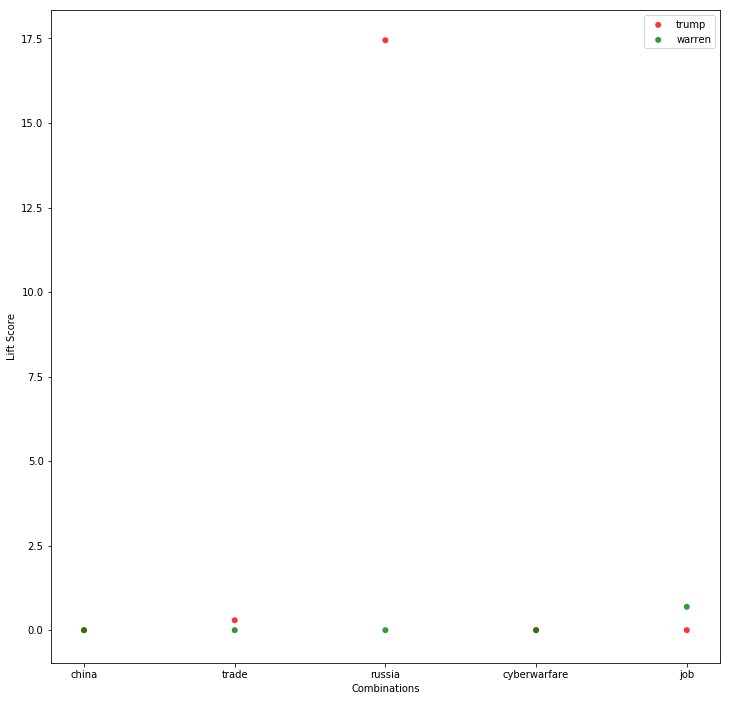

In [58]:
# Plotting dicts for the MDS map
plotarr={}
for b in candList:
    plotarr[b]=[]
for i in lift_scores:
    plotarr[i[0]].append(lift_scores[i])

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)
colors = ("red", "green", "blue","black","orange")
groups = plotarr.keys()

for lift, color, group in zip(plotarr, colors, groups):
#     plt.scatter(attributeList,plotarr[lift])
#     ax.scatter(attributeList, plotarr[lift])
    ax.scatter(attributeList, plotarr[lift], alpha=0.8, c=color, edgecolors='none', label=group)

plt.xlabel('Combinations')
plt.ylabel('Lift Score')
plt.legend(loc=1)
plt.show()

Sentiment

In [80]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/whitthyde/nltk_data...


True

In [ ]:
def sentiment_value(tweet):
    analyser = sentiment()
    result = analyser.polarity_scores(tweet)
    score = result['compound']
    return round(score,1)

time_line=[]
for i in df['Tweets']:
    
    print(i,'-',sentiment_value(i))
